In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import pandas as pd
import cvxpy as cp
import math
import itertools
import scipy.stats as stats

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size = 14)
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

### Loading Data

In [2]:
sheet_assets = pd.read_excel('thesis_dataset.xlsx', sheet_name='Assets')
assets = ['US Equities','Intl Equities','US Gov Bonds','Intl Gov Bonds']
mtx_assets = np.array(sheet_assets[assets])
ASSET_NAMES = ['U.S. Equities','Intl. Equities','U.S. Gov. Bonds','Intl. Gov. Bonds']

In [3]:
class Regime(object):
    def __init__(self, mtx_historical, base_asset = 0):
        # historical  results to fit
        self.mtx_historical = mtx_historical
        self.exp_return = np.mean(mtx_historical, axis = 0)
        self.cov_return = np.cov(mtx_historical.T)

        self.base_asset = base_asset

        self.exp_return_normal = None
        self.exp_return_crash = None
        self.cov_return_normal = None
        self.cov_return_crash = None
        
        self.array_regime = None

        # crash is 0th dimension, normal is 1st dimension
        # row is previous month, column is the next month
        self.transition_matrix = None

        self.prob_normal = None
        self.prob_crash = None

    @classmethod
    def l1TrendFiltering(cls, returns, lam):
        '''estimate a piecewise constant function to a time series of returns'''
        n = len(returns)

        # first-order difference matrix, dimension (n-1)xn
        D = np.diag([1]*n) + np.diag([-1]*(n-1),k=1)
        D = D[:-1,:]

        # formulate and solve optimization problem using CVXPY
        beta_hat = cp.Variable(n)
        objective = cp.Minimize(cp.sum_squares(returns-beta_hat) + 
            lam*cp.norm(cp.matmul(D, beta_hat), 1))
        prob = cp.Problem(objective)
        prob.solve()

        return(beta_hat.value)

    @classmethod
    def convertToIndex(cls, indicator_regime):
        if indicator_regime == -1:
            return 0
        else:
            return 1

    @classmethod
    def markovChain(cls, array_regimes):
        '''Given array of regimes, generate markov chain with appropriate probs'''

        markov_freq = np.zeros((2,2))

        for curr_period in range(len(array_regimes) - 1):
            next_period = curr_period + 1
            curr_index = Regime.convertToIndex(array_regimes[curr_period])
            next_index = Regime.convertToIndex(array_regimes[next_period])

            markov_freq[curr_index, next_index] += 1

        return markov_freq / np.sum(markov_freq, axis=1, keepdims=1)

    # identify economic regimes from time series data
    def identifyRegimes(self, lam, offset):
        '''
            This function should generate: covariance matrices, exp returns, markov transition matrix
        '''
        array_regime = np.sign(Regime.l1TrendFiltering(self.mtx_historical[:,self.base_asset], lam) - offset)
        self.array_regime = array_regime
        self.prob_normal = (array_regime==1).sum() / len(array_regime)
        self.prob_crash = (array_regime==-1).sum() / len(array_regime)

        mtx_historical_normal = self.mtx_historical[array_regime==1,:]
        mtx_historical_crash = self.mtx_historical[array_regime==-1,:]

        # Calculate the monthly historical covariance of the assets
        self.cov_return_normal = np.cov(mtx_historical_normal.T)
        self.cov_return_crash = np.cov(mtx_historical_crash.T)

        self.exp_return_normal = np.mean(mtx_historical_normal, axis=0)
        self.exp_return_crash = np.mean(mtx_historical_crash, axis=0)
        self.markov_transitions = Regime.markovChain(array_regime)

## All these functions are for simulating asset returns.

In [4]:
class Simulate(object):
    '''Class with methods for simulation'''
    
    @classmethod
    def regime_transition(cls, prev_regime):
        """Markov chain for current regime.

        Args:
            prev_regime: Either -1 (+1) for crash (normal) regime.

        Returns:
            -1 or +1 depending on what the next regime is
        """
        # [0.83636364 0.16363636]
        # [0.03164557 0.96835443]

        # if normal, 0.98 chance of next period normal
        if prev_regime == 1:
            p_normal = 0.96835443
        # else crash, 0.125 chance of next period normal
        else:
            p_normal = 0.16363636

        if np.random.uniform() < p_normal:
            return 1
        else:
            return -1

    @classmethod
    def return_single_period(cls, mu_normal, cov_normal, mu_crash, cov_crash):
        """Generate a single period asset return.

        Uses a regime-based approach to generate asset returns.
        
        Returns:
            A function which takes regime indicator to return assets
        """
        def f(indicator_regime):
            if indicator_regime == 1:
                return(np.random.multivariate_normal(mu_normal,cov_normal))
            elif indicator_regime == -1:
                return(np.random.multivariate_normal(mu_crash,cov_crash))
            else:
                raise ValueError('Regime indicator must be either +1 or -1.'
                                 'You gave %d.' % indicator_regime)
        return(f)
    
    @classmethod
    def return_series(cls,num_scenarios, num_periods, f_gen_return, f_gen_regime, random_seed=0):
        """Generate a sequence of asset returns

        Uses a regime-based approach to generate asset returns for a given number of
        scenarios and months

        Returns:
            Numpy array with dimension (num_scenarios, num_periods, num_assets), 
            which is a sequence of asset returns
        """
        # set random seed
        if random_seed != None:
            np.random.seed(random_seed)
        
        num_assets = f_gen_return(1).shape[0] # generate to find num_assets
        matrix_returns = np.zeros((num_scenarios, num_periods, num_assets))

        for s in range(num_scenarios):
            indicator_regime = 1
            for t in range(num_periods):
                matrix_returns[s,t,:] = f_gen_return(indicator_regime)
                # determine regime for upcoming month based on previous month regime
                indicator_regime = f_gen_regime(indicator_regime)

        return matrix_returns

In [5]:
regime_obj = Regime(mtx_assets)
regime_obj.identifyRegimes(0.1,0)
print(regime_obj.markov_transitions)
print("")
np.savetxt("array_regime.csv", regime_obj.array_regime, delimiter=",")
print(regime_obj.exp_return_normal)
print("")
print(regime_obj.exp_return_crash)

[[0.83636364 0.16363636]
 [0.03164557 0.96835443]]

[0.01834034 0.01408909 0.00371281 0.00350545]

[-0.04321955 -0.04068112  0.0110339   0.00974724]


## Plotting Regimes on US Equities

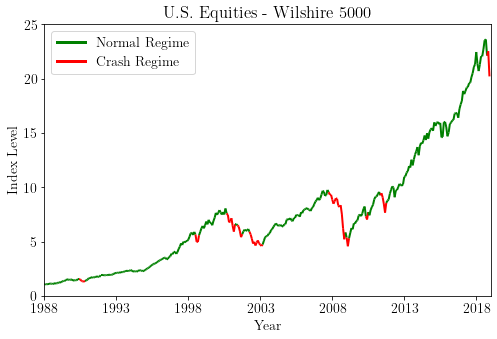

In [6]:
# starter code from: 
# https://matplotlib.org/gallery/lines_bars_and_markers/multicolored_line.html
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.lines import Line2D

x = np.array(range(len( sheet_assets['US Equities'] )))
y = np.array(np.cumprod(1 + sheet_assets['US Equities']))
indicator = regime_obj.array_regime

# Create a set of line segments so that we can color them individually
# This creates the points as a N x 1 x 2 array so that we can stack points
# together easily to get the segments. The segments array for line collection
# needs to be (numlines) x (points per line) x 2 (for x and y)
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

fig, ax = plt.subplots(figsize=(8,5))

# Use a boundary norm
cmap = ListedColormap(['r', 'g'])
norm = BoundaryNorm([-10, 0, 10], cmap.N)
lc = LineCollection(segments, cmap=cmap, norm=norm)
lc.set_array(indicator)
lc.set_linewidth(2)
line = ax.add_collection(lc)

# custom legend
custom_lines = [Line2D([0], [0], color='g', lw=3),
                Line2D([0], [0], color='r', lw=3)]
ax.legend(custom_lines, ['Normal Regime', 'Crash Regime'],loc='upper left')

plt.title('U.S. Equities - Wilshire 5000')
plt.xlabel('Year')
plt.ylabel('Index Level')
ax.set_xlim(x.min(), x.max()+1)
ax.set_ylim(0, 25)
plt.xticks(range(0, len(y), 60), 
           ['1988','1993','1998','2003','2008','2013','2018'])
plt.savefig('fig_usequities.png',dpi=300)
plt.show()

[29, 30, 31, 32, 33, 126, 127, 128, 152, 153, 154, 155, 156, 157, 158, 161, 162, 163, 164, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 252, 253, 268, 269, 280, 281, 282, 283, 284, 369, 370, 371]


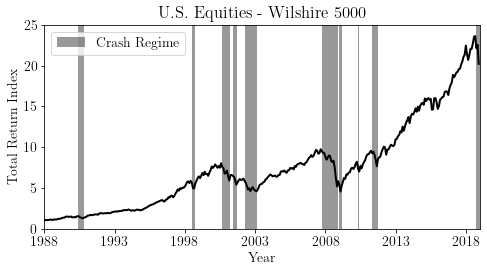

In [12]:
list_indices = []
for i in range(len(regime_obj.array_regime)):
    if regime_obj.array_regime[i] == -1:
        list_indices.append(i)
        
print(list_indices)
list_indices_2 = [(29,34), (126,129), (152,159), (161,165),(171,182),(237,251),
                  (252,254),(268,269),(280,285),(369,372)]

x = np.array(range(len( sheet_assets['US Equities'] )))
y = np.array(np.cumprod(1 + sheet_assets['US Equities']))

fig, ax = plt.subplots(figsize=(7,4))

count = 0
for pair in list_indices_2:
    count += 1
    if count == 1:
        ax.axvspan(pair[0], pair[1], alpha=0.4, facecolor='k',label='Crash Regime')
    
    else:
        ax.axvspan(pair[0], pair[1], alpha=0.4, facecolor='k')

plt.plot(x,y,linewidth=2,color='k')

plt.title('U.S. Equities - Wilshire 5000')
plt.xlabel('Year')
plt.ylabel('Total Return Index')
ax.set_xlim(x.min(), x.max()+1)
ax.set_ylim(0, 25)
plt.xticks(range(0, len(y), 60), 
           ['1988','1993','1998','2003','2008','2013','2018'])

plt.legend()
plt.tight_layout()
plt.savefig('fig_usequities.png',dpi=300)
plt.show()

## Fit Long-Term Capital Markets Assumptions

In [7]:
def ltcma(regime_obj, ret_multiplier):
    n_years = 10000
    n_assets = 4

    return_normal = np.multiply(regime_obj.exp_return_normal, ret_multiplier)
    return_crash = np.multiply(regime_obj.exp_return_crash, ret_multiplier)
    
    f_asset = Simulate.return_single_period(return_normal,
                                            regime_obj.cov_return_normal,
                                            return_crash,
                                            regime_obj.cov_return_crash) 

    mtx_returns_plot = Simulate.return_series(1,n_years*12,f_asset,Simulate.regime_transition)[0,:,:]

    mtx_returns_years = np.zeros((n_years,n_assets))
    for n in range(n_years):
        for i in range(n_assets):
            mtx_returns_years[n,i] = np.prod(1 + mtx_returns_plot[n*12:(n+1)*12,i]) - 1

    np.set_printoptions(precision=6)
    print('Geometric mean')
    for i in range(n_assets):
        print(assets[i], stats.gmean(1 + mtx_returns_years[:,i]) - 1)

    print('Arithmetic mean')
    for i in range(n_assets):
        print(assets[i], np.mean(mtx_returns_years[:,i]))

    print('Standard deviation')
    for i in range(n_assets):
        print(assets[i], np.round(np.std(mtx_returns_years[:,i]),4))

    print('Skewness')
    for i in range(4):
        print(assets[i], stats.skew(mtx_returns_years[:,i]))

    print('Kurtosis')
    for i in range(4):
        print(assets[i], np.round(stats.kurtosis(mtx_returns_years[:,i]),2))

# High LTCMA: Equity at 7% geometric mean, Bond at 3% geometric mean
high_ret_multiplier = [0.79158,1.3647,0.515,0.6138]

# Baseline LTCMA: Equity at 6% geometric mean, Bond at 3% geometric mean
baseline_ret_multiplier = [0.6958,1.20285,0.515,0.6138]

# Low LTCMA: Equity at 5% geometric mean, Bond at 3% geometric mean
low_ret_multiplier = [0.5026,0.8818,0.515,0.6138]

list_multipliers = [low_ret_multiplier, baseline_ret_multiplier, high_ret_multiplier]
list_names = ['Low LTCMA', 'Baseline LTCMA', 'High LTCMA']

for ret_multiplier, name in zip(list_multipliers, list_names):
    print(name)
    print(np.round(np.multiply(regime_obj.exp_return_normal, ret_multiplier)*100,2))
    print(np.round(np.multiply(regime_obj.exp_return_crash, ret_multiplier)*100,2))


for ret_multiplier, name in zip(list_multipliers, list_names):
    print('\nResults for', name)
    ltcma(regime_obj, ret_multiplier)

Low LTCMA
[0.92 1.24 0.19 0.22]
[-2.17 -3.59  0.57  0.6 ]
Baseline LTCMA
[1.28 1.69 0.19 0.22]
[-3.01 -4.89  0.57  0.6 ]
High LTCMA
[1.45 1.92 0.19 0.22]
[-3.42 -5.55  0.57  0.6 ]

Results for Low LTCMA
Geometric mean
US Equities 0.04000361373806016
Intl Equities 0.04000262493162787
US Gov Bonds 0.029938383923539424
Intl Gov Bonds 0.02999973141332113
Arithmetic mean
US Equities 0.05395395075699639
Intl Equities 0.06519661533759993
US Gov Bonds 0.03100751338761677
Intl Gov Bonds 0.03385843642664444
Standard deviation
US Equities 0.1667
Intl Equities 0.2209
US Gov Bonds 0.0471
Intl Gov Bonds 0.0896
Skewness
US Equities -0.1747965557562522
Intl Equities -0.19082846054716363
US Gov Bonds 0.2387284922112376
Intl Gov Bonds 0.2875117351344678
Kurtosis
US Equities 0.24
Intl Equities 0.19
US Gov Bonds 0.21
Intl Gov Bonds 0.35

Results for Baseline LTCMA
Geometric mean
US Equities 0.06004479671748997
Intl Equities 0.060000544222743146
US Gov Bonds 0.029938383923539424
Intl Gov Bonds 0.0299997314

## Plotting Histogram of Simulated Returns

In [8]:
n_years = 10000
n_assets = 4
    
return_normal = np.multiply(regime_obj.exp_return_normal, baseline_ret_multiplier)
return_crash = np.multiply(regime_obj.exp_return_crash, baseline_ret_multiplier)

f_asset = Simulate.return_single_period(return_normal,
                                        regime_obj.cov_return_normal,
                                        return_crash,
                                        regime_obj.cov_return_crash) 

mtx_returns_plot = Simulate.return_series(1,n_years*12,f_asset,Simulate.regime_transition)[0,:,:]

mtx_returns_years = np.zeros((n_years,n_assets))
for n in range(n_years):
    for i in range(n_assets):
        mtx_returns_years[n,i] = np.prod(1 + mtx_returns_plot[n*12:(n+1)*12,i]) - 1

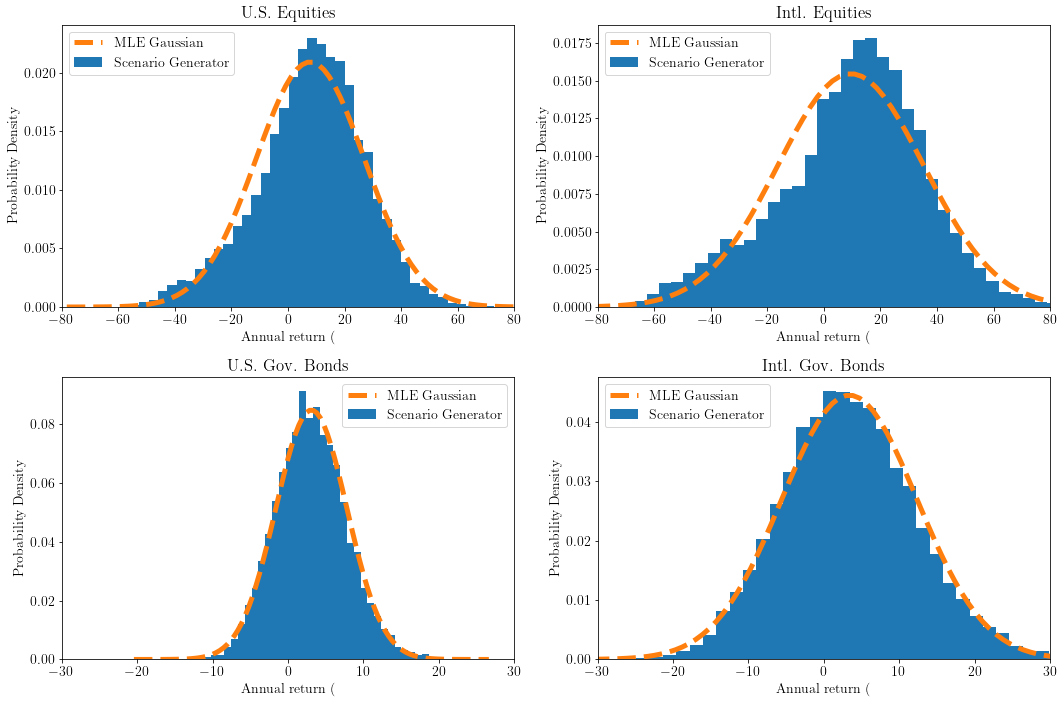

In [17]:
xlims = [[-80,80],[-80,80],[-30,30],[-30,30]]
ylim = [0,0.1]
fig = plt.figure(figsize=(15,10))
for i in range(n_assets):
    x = mtx_returns_years[:,i]*100
    ax = fig.add_subplot(2,2,i+1)
    ax.set_xlim(xlims[i])
    
    mu_x = np.mean(x)
    std_x = np.std(x)

    xs = np.linspace(mu_x - 5*std_x, mu_x + 5*std_x, 100)
    ax.hist(x, density=True, bins=40,label='Scenario Generator')
    ax.plot(xs, stats.norm.pdf(xs, mu_x, std_x),linestyle='--',linewidth=5,label='MLE Gaussian')
    ax.set_ylabel('Probability Density')
    ax.set_xlabel('Annual return (%)')

    ax.set_title(ASSET_NAMES[i])
    ax.legend()
plt.tight_layout()
plt.savefig('histogram.png',dpi=300)
plt.show()

## Generate Return Scenarios

In [9]:
# return scenario for debugging
n_years = 75
n_assets = 4
n_sim = 10

return_normal = np.multiply(regime_obj.exp_return_normal, baseline_ret_multiplier)
return_crash = np.multiply(regime_obj.exp_return_crash, baseline_ret_multiplier)

f_asset = Simulate.return_single_period(return_normal,
                                        regime_obj.cov_return_normal,
                                        return_crash,
                                        regime_obj.cov_return_crash) 
mtx_returns = Simulate.return_series(n_sim,n_years*12,f_asset,Simulate.regime_transition)

np.save('numpy/mtx_returns_test',mtx_returns)

In [11]:
n_years = 75
n_assets = 4
n_sim = 1000 # find_me

list_multipliers = [low_ret_multiplier, baseline_ret_multiplier, high_ret_multiplier]
list_file_names = ['numpy/mtx_returns_low', 'numpy/mtx_returns_baseline', 'numpy/mtx_returns_high']

for ret_multiplier, file_name in zip(list_multipliers, list_file_names):
    
    return_normal = np.multiply(regime_obj.exp_return_normal, ret_multiplier)
    return_crash = np.multiply(regime_obj.exp_return_crash, ret_multiplier)

    f_asset = Simulate.return_single_period(return_normal,
                                            regime_obj.cov_return_normal,
                                            return_crash,
                                            regime_obj.cov_return_crash) 
    
    mtx_returns = Simulate.return_series(n_sim,n_years*12,f_asset,Simulate.regime_transition)

    np.save(file_name,mtx_returns)

Adapted from Chen (2019)